# Actor Critic Continuous
> by Khizr Ali Pardhan | Alik604

Apprently Actor Critic low-key sucks compared to other Policy Gradient algos, such as DDPG

Hence, I'm just running this for Amusement and practice reading code. 

In [1]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import pickle
import gym
import matplotlib.pyplot as plt
from utils import plotLearning
from gym import wrappers

In [ ]:
agent = pickle.load(open("_actor_crt_mountaincar_con-1.2488451868607289_epoch103.p",'rb'))

env = gym.make('MountainCarContinuous-v0')
score_history = []

In [2]:
class GenericNetwork(nn.Module):
    def __init__(self, alpha, input_dims, fc1_dims, fc2_dims,
                 n_actions):
        super(GenericNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cuda:1')
        self.to(self.device)

    def forward(self, observation):
        state = T.tensor(observation, dtype=T.float).to(self.device)
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [3]:
class Agent(object):
    def __init__(self, alpha, beta, input_dims, gamma=0.99, n_actions=2,
                 layer1_size=256, layer2_size=256, n_outputs=1):
        self.gamma = gamma
        self.log_probs = None
        self.n_outputs = n_outputs
        self.actor = GenericNetwork(alpha, input_dims, layer1_size,
                                           layer2_size, n_actions=n_actions)
        self.critic = GenericNetwork(beta, input_dims, layer1_size,
                                            layer2_size, n_actions=1)

    def choose_action(self, observation):
        mu, sigma  = self.actor.forward(observation)#.to(self.actor.device)
        sigma = T.exp(sigma)
        action_probs = T.distributions.Normal(mu, sigma)
        probs = action_probs.sample(sample_shape=T.Size([self.n_outputs]))
        self.log_probs = action_probs.log_prob(probs).to(self.actor.device)
        action = T.tanh(probs)

        return action.item()

    def learn(self, state, reward, new_state, done):
        self.actor.optimizer.zero_grad()
        self.critic.optimizer.zero_grad()

        critic_value_ = self.critic.forward(new_state)
        critic_value = self.critic.forward(state)
        reward = T.tensor(reward, dtype=T.float).to(self.actor.device)
        delta = ((reward + self.gamma*critic_value_*(1-int(done))) - \
                                                                critic_value)

        actor_loss = -self.log_probs * delta
        critic_loss = delta**2

        (actor_loss + critic_loss).backward()

        self.actor.optimizer.step()
        self.critic.optimizer.step()

In [11]:
agent = Agent(alpha=0.0005, beta=0.0001, input_dims=[2], gamma=0.99,
# agent = Agent(alpha=0.000005, beta=0.00001, input_dims=[2], gamma=0.99,
              layer1_size=16, layer2_size=16)

env = gym.make('MountainCarContinuous-v0')
score_history = []
num_episodes = 100
for i in range(num_episodes):
    #env = wrappers.Monitor(env, "tmp/mountaincar-continuous-trained-1",
    #                        video_callable=lambda episode_id: True, force=True)
    done = False
    score = 0
    observation = env.reset()
    while not done:
        action = np.array(agent.choose_action(observation)).reshape((1,))
        observation_, reward, done, info = env.step(action)
        agent.learn(observation, reward, observation_, done)
        observation = observation_
        score += reward
    score_history.append(score)
    print('episode: ', i,'score: %.2f' % score)
filename = 'mountaincar-continuous-old-actor-critic-100games.png'

episode:  0 score: -24.69
episode:  1 score: -4.15
episode:  2 score: -1.34
episode:  3 score: -0.52
episode:  4 score: -0.31
episode:  5 score: -1.77
episode:  6 score: -12.08
episode:  7 score: -0.46
episode:  8 score: -1.11
episode:  9 score: -6.18
episode:  10 score: -3.40
episode:  11 score: -10.91
episode:  12 score: -11.28
episode:  13 score: -0.47
episode:  14 score: -0.07
episode:  15 score: -4.46
episode:  16 score: -14.04
episode:  17 score: -6.41
episode:  18 score: -0.11
episode:  19 score: -1.96
episode:  20 score: -4.45
episode:  21 score: -9.26
episode:  22 score: -15.57
episode:  23 score: -23.81
episode:  24 score: -22.47
episode:  25 score: -28.60
episode:  26 score: -20.19
episode:  27 score: -7.56
episode:  28 score: -10.53
episode:  29 score: -14.63
episode:  30 score: -3.69
episode:  31 score: -7.72
episode:  32 score: -18.50
episode:  33 score: -24.13
episode:  34 score: -36.24
episode:  35 score: -24.12
episode:  36 score: -17.80
episode:  37 score: -9.43
episo

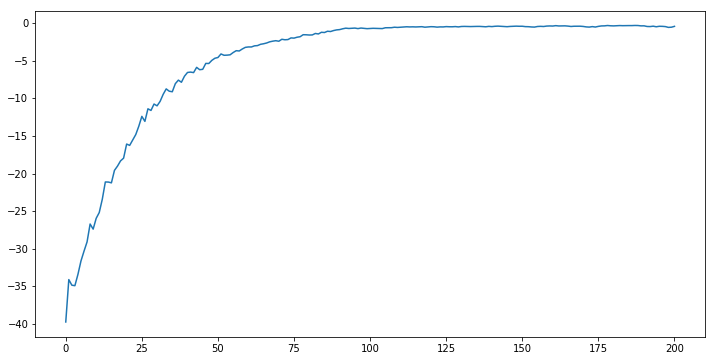

In [8]:
plt.figure(figsize=(12,6))
plt.plot(score_history)

In [9]:
def demo(n_demos=1):
    for i in range(n_demos):
        done = False
        score = 0
        observation = env.reset()
        while not done:
            action = np.array(agent.choose_action(observation)).reshape((1,))
            observation_, reward, done, info = env.step(action)
        #     agent.learn(observation, reward, observation_, done)
            observation = observation_
            score += reward
            env.render()
        score_history.append(score)
        print('episode: ', i,'score: %.2f' % score)
        env.close()
        
demo()

episode:  0 score: -0.46


In [7]:
def train_more(n_games=100):
    for i in range(n_games):
        done = False
        score = 0
        observation = env.reset()
        while not done:
            action = np.array(agent.choose_action(observation)).reshape((1,))
            observation_, reward, done, info = env.step(action)
            agent.learn(observation, reward, observation_, done)
            observation = observation_
            score += reward
        score_history.append(score)
        print('episode: ', i,'score: %.2f' % score)
    
    if score > 50:
        pickle.dump(agent, open(f'_actor_crt_mountaincar_con{score}_epoch{len(score_history)}.p', "wb" ))   
            
train_more(n_games=100)

episode:  0 score: -0.69
episode:  1 score: -0.71
episode:  2 score: -0.71
episode:  3 score: -0.73
episode:  4 score: -0.62
episode:  5 score: -0.61
episode:  6 score: -0.61
episode:  7 score: -0.55
episode:  8 score: -0.58
episode:  9 score: -0.55
episode:  10 score: -0.51
episode:  11 score: -0.49
episode:  12 score: -0.51
episode:  13 score: -0.50
episode:  14 score: -0.51
episode:  15 score: -0.49
episode:  16 score: -0.48
episode:  17 score: -0.55
episode:  18 score: -0.52
episode:  19 score: -0.48
episode:  20 score: -0.49
episode:  21 score: -0.54
episode:  22 score: -0.51
episode:  23 score: -0.51
episode:  24 score: -0.47
episode:  25 score: -0.49
episode:  26 score: -0.49
episode:  27 score: -0.46
episode:  28 score: -0.51
episode:  29 score: -0.45
episode:  30 score: -0.44
episode:  31 score: -0.46
episode:  32 score: -0.46
episode:  33 score: -0.45
episode:  34 score: -0.44
episode:  35 score: -0.44
episode:  36 score: -0.46
episode:  37 score: -0.49
episode:  38 score: -0

In [9]:
# agent.alpha=0.000005
# agent.beta=0.00001

In [10]:
# pickle.dump(agent, open(f'_actor_crt_mountaincar_con{score}_epoch{len(score_history)}.p', "wb" ))   

In [12]:
agent = Agent(alpha=0.005, beta=0.001, input_dims=[2], gamma=0.99,
# agent = Agent(alpha=0.000005, beta=0.00001, input_dims=[2], gamma=0.99,
              layer1_size=16, layer2_size=16)

env = gym.make('MountainCarContinuous-v0')
score_history = []
num_episodes = 100
for i in range(num_episodes):
    #env = wrappers.Monitor(env, "tmp/mountaincar-continuous-trained-1",
    #                        video_callable=lambda episode_id: True, force=True)
    done = False
    score = 0
    observation = env.reset()
    while not done:
        action = np.array(agent.choose_action(observation)).reshape((1,))
        observation_, reward, done, info = env.step(action)
        agent.learn(observation, reward, observation_, done)
        observation = observation_
        score += reward
    score_history.append(score)
    print('episode: ', i,'score: %.2f' % score)
filename = 'mountaincar-continuous-old-actor-critic-100games.png'

episode:  0 score: -9.50
episode:  1 score: -5.72
episode:  2 score: -2.36
episode:  3 score: -1.89
episode:  4 score: -5.06
episode:  5 score: -2.09
episode:  6 score: -19.83
episode:  7 score: -28.01
episode:  8 score: -46.94
episode:  9 score: -26.58
episode:  10 score: -64.17
episode:  11 score: -31.94
episode:  12 score: -4.70
episode:  13 score: -5.20
episode:  14 score: -11.67
episode:  15 score: -2.25
episode:  16 score: -2.27
episode:  17 score: -1.02
episode:  18 score: -3.95
episode:  19 score: -4.93
episode:  20 score: -9.71
episode:  21 score: -7.80
episode:  22 score: -4.23
episode:  23 score: -5.26
episode:  24 score: -2.09
episode:  25 score: -13.90
episode:  26 score: -3.62
episode:  27 score: -4.04
episode:  28 score: -4.21
episode:  29 score: -5.84
episode:  30 score: -2.25
episode:  31 score: -3.08
episode:  32 score: -2.27
episode:  33 score: -3.04
episode:  34 score: -8.44
episode:  35 score: -0.71
episode:  36 score: -3.01
episode:  37 score: -2.83
episode:  38 s

In [13]:
agent = Agent(alpha=0.0005, beta=0.0001, input_dims=[2], gamma=0.99,
# agent = Agent(alpha=0.000005, beta=0.00001, input_dims=[2], gamma=0.99,
              layer1_size=160, layer2_size=160)

env = gym.make('MountainCarContinuous-v0')
score_history = []
num_episodes = 100
for i in range(num_episodes):
    #env = wrappers.Monitor(env, "tmp/mountaincar-continuous-trained-1",
    #                        video_callable=lambda episode_id: True, force=True)
    done = False
    score = 0
    observation = env.reset()
    while not done:
        action = np.array(agent.choose_action(observation)).reshape((1,))
        observation_, reward, done, info = env.step(action)
        agent.learn(observation, reward, observation_, done)
        observation = observation_
        score += reward
    score_history.append(score)
    print('episode: ', i,'score: %.2f' % score)
filename = 'mountaincar-continuous-old-actor-critic-100games.png'

episode:  0 score: -5.61
episode:  1 score: -13.46
episode:  2 score: -5.97
episode:  3 score: -13.25
episode:  4 score: -15.61
episode:  5 score: -4.34
episode:  6 score: -19.91
episode:  7 score: -11.44
episode:  8 score: -6.09
episode:  9 score: -4.15
episode:  10 score: -14.35
episode:  11 score: -28.24
episode:  12 score: -24.11
episode:  13 score: -14.26
episode:  14 score: -11.57
episode:  15 score: -5.62
episode:  16 score: -7.24
episode:  17 score: -7.35
episode:  18 score: -10.86
episode:  19 score: -9.59
episode:  20 score: -1.46
episode:  21 score: -3.40
episode:  22 score: -1.26
episode:  23 score: -8.49
episode:  24 score: -17.36
episode:  25 score: -5.50
episode:  26 score: -2.98
episode:  27 score: -7.09
episode:  28 score: -1.15
episode:  29 score: -8.28
episode:  30 score: -49.13
episode:  31 score: -4.80
episode:  32 score: -28.69
episode:  33 score: -76.67
episode:  34 score: -83.80
episode:  35 score: -95.89
episode:  36 score: -98.59
episode:  37 score: -91.77
epi

In [ ]:
# agent = Agent(alpha=0.0005, beta=0.0001, input_dims=[2], gamma=0.99,
agent = Agent(alpha=0.000005, beta=0.00001, input_dims=[2], gamma=0.99,
              layer1_size=160, layer2_size=160)

env = gym.make('MountainCarContinuous-v0')
score_history = []
num_episodes = 100
for i in range(num_episodes):
    #env = wrappers.Monitor(env, "tmp/mountaincar-continuous-trained-1",
    #                        video_callable=lambda episode_id: True, force=True)
    done = False
    score = 0
    observation = env.reset()
    while not done:
        action = np.array(agent.choose_action(observation)).reshape((1,))
        observation_, reward, done, info = env.step(action)
        agent.learn(observation, reward, observation_, done)
        observation = observation_
        score += reward
    score_history.append(score)
    print('episode: ', i,'score: %.2f' % score)
filename = 'mountaincar-continuous-old-actor-critic-100games.png'